
<div class="alert alert-block alert-success">
<b>Project: NYC energy consumption</b> 

* Link: https://data.cityofnewyork.us/Environment/NYC-Building-Energy-and-Water-Data-Disclosure-for-/5zyy-y8am.
</div>
<b>Report:</b> New York city local Law 84 of 2009 (LL84) requires annual energy and water benchmarking data to be submitted by owners of buildings with more than 50,000 square feet. This data is collected via the Environmental Protection Agency's (EPA).

<b>Objective and Scope:</b> The Department of Sustainable Development in New York City is actively engaged in a comprehensive assessment of the city's energy performance. The primary focus lies in identifying areas where enhancements can be made to bolster sustainability initiatives and reduce environmental impact.

<b>Analytical Framework:</b> This report delves into the intricacies of energy consumption across five distinct districts in New York City. By leveraging a comprehensive dataset, which encompasses crucial metrics such as natural gas, electricity, water, and fuel consumption, the analysis aims to provide a nuanced understanding of the energy landscape in each district.

<b>Key Findings and Recommendations:</b> Through meticulous examination of critical features and insightful visualizations, this report derives pertinent conclusions. The findings not only shed light on the current state of energy consumption in the specified districts but also offer valuable insights for strategic planning and targeted improvements.

In summary, this report serves as a vital tool for stakeholders, offering a comprehensive analysis of energy utilization in New York City's diverse districts and paving the way for informed decision-making to advance sustainable practices.



<div class="alert alert-block alert-info">
<b>Data Processing:</b> 
</div>


In [1]:
import warnings

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import altair as alt
from shapely.geometry import Point
from sklearn.preprocessing import LabelEncoder
from vega_datasets import data
import folium
from branca.colormap import linear
import Lists

In [2]:
warnings.simplefilter(action='ignore')
T1=pd.read_csv('NYC_Building_Energy_and_Water_Data_Disclosure_for_Local_Law_84__2023-Present__20231226.csv')
T1=T1.drop(columns=Lists.Columns_to_Drop)

In [3]:
T1.dropna(subset=['Latitude', 'Longitude'], inplace=True)
T1.replace({'Not Available': pd.NA}, inplace=True)

In [4]:
T1[Lists.columns_to_convert] = T1[Lists.columns_to_convert].apply(lambda x: pd.to_numeric(x.str.replace(',', ''), errors='coerce') if x.dtype == 'O' else x)
T1[Lists.columns_to_convert] = T1[Lists.columns_to_convert].astype(float)

In [5]:
warnings.simplefilter(action='ignore')
points= T1.apply(lambda row: Point(row.Longitude, row.Latitude), axis=1)
T2=gpd.GeoDataFrame(T1, geometry=points)
T2.crs = {'init': 'epsg:4326'}


<div class="alert alert-block alert-success">
<b>For NYC district borders another dataset is added for border shapes</b> 


In [6]:
NYC_Map = pd.read_csv('DSNY_Districts_20231227.csv')
NYC_Map['geometry'] = gpd.GeoSeries.from_wkt(NYC_Map['multipolygon'])
gdf = gpd.GeoDataFrame(NYC_Map, geometry='geometry')

In [7]:
conditions = [
    gdf['DISTRICT'].str.contains('BX', case=False),
    gdf['DISTRICT'].str.contains('MN', case=False),
    gdf['DISTRICT'].str.contains('QE|QW', case=False),
    gdf['DISTRICT'].str.contains('BKN|BKS', case=False),
    gdf['DISTRICT'].str.contains('SI', case=False)
]

choices = ['Bronx', 'Manhattan', 'Queens', 'Brooklyn', 'Staten Island']
gdf['District_Name'] = np.select(conditions, choices, default='Unknown')
gdf.crs = "EPSG:4326"
gdf_transformed = gdf.to_crs("EPSG:4326")



In [8]:

T2 = T2.to_crs(gdf_transformed.crs)
NYC_Final = gpd.sjoin(gdf_transformed,T2, how='inner', predicate='intersects')


<b> Note ! </b>

Running the codes generates user interactive maps. For the sake of file size, they are kept only as screenshots.

<div class="alert alert-block alert-info">
<b>Chart N1:</b> 
</div>
The interactive chart presented below delineates five districts alongside their respective subdistricts, characterized by the average value of Site Energy Use Intensity (Site EUI), denoting the ratio of Site Energy Use to property square footage. This metric assumes significance as it serves as a pivotal indicator of overall performance in the given context.

In addition to employing color shading to differentiate between districts, each district is accompanied by its designated "worst-case scenario" markup, representing the highest Site EUI within the district, as well as the most unfavorable case across all districts within New York City.

Remarkably, an intriguing observation emerges as subdistricts exhibiting the poorest performance, as evidenced by higher Site EUI values (measured in kBtu/ft²), are predominantly situated in Queens.

In [ ]:
warnings.simplefilter(action='ignore')

grouped_data = NYC_Final.groupby(['District_Name', 'DISTRICT'])['Site EUI (kBtu/ft²)'].mean().reset_index().round()
grouped_data['Rank_within_District'] = grouped_data.groupby('District_Name')['Site EUI (kBtu/ft²)'].rank(ascending=False)
grouped_data_district = grouped_data.copy()
grouped_data_district['Rank_within_City'] = grouped_data_district['Site EUI (kBtu/ft²)'].rank(ascending=False)

T3 = gdf_transformed.merge(grouped_data_district, on='DISTRICT', how='left')
districts_map = folium.Map(location=[40.708800, -73.995140], zoom_start=11)
quantiles = np.percentile(T3['Site EUI (kBtu/ft²)'].dropna(), [25, 50, 75])
colormap = linear.RdYlGn_11.scale(min(quantiles), max(quantiles))
colormap.colors = colormap.colors[::-1]

def color_function(x):
    if x['properties']['Site EUI (kBtu/ft²)'] is None:
        return 'gray'  # or any default color for missing values
    else:
        return colormap(x['properties']['Site EUI (kBtu/ft²)'])

def add_marker(map_obj, location, popup_text, icon):
    marker = folium.Marker(location=location, popup=popup_text, icon=icon)
    marker.add_to(map_obj)

district_layers = {}
for district_name in T3['District_Name_x'].unique():
    subset = T3[T3['District_Name_x'] == district_name]
    
    geojson_layer = folium.GeoJson(
        subset,
        name=district_name,
        style_function=lambda x: {
            'fillColor': color_function(x),
            'color': 'black',
            'weight': 1,
            'fillOpacity': 0.7
        },
        highlight_function=lambda x: {
            'fillColor': 'yellow',
            'color': 'black',
            'weight': 2,
            'fillOpacity': 0.7
        },
        tooltip=folium.features.GeoJsonTooltip(
            fields=['District_Name_x','DISTRICT', 'Site EUI (kBtu/ft²)',  'Rank_within_District', 'Rank_within_City'], 
            aliases=['District:','Subdistrict:', 'EUI average Score:',  'Rank within District:', 'Rank within City:'], 
            style=("background-color: white; color: #333333; font-size: 12px; padding: 10px;")
        )
    )

    geojson_layer.add_to(districts_map)
    
    for _, row in subset[subset['Rank_within_District'] == 1].iterrows():
        if row['geometry'].geom_type == 'MultiPolygon':
            location = [row['geometry'].representative_point().y, row['geometry'].representative_point().x]
        else:
            location = [row['geometry'].y, row['geometry'].x]
        popup_text = f"{row['District_Name_x']} - Rank 1 in District"
        add_marker(districts_map, location, popup_text, folium.Icon( prefix='glyphicon'))
    city_rank_1_rows = subset[subset['Rank_within_City'] == 1]
    if not city_rank_1_rows.empty:
        city_rank_1_location = [city_rank_1_rows['geometry'].centroid.y.values[0] + 0.01,  # Adjust the y-coordinate slightly
                                city_rank_1_rows['geometry'].centroid.x.values[0]-0.009]
        city_rank_1_popup_text = f"{district_name} - Rank 1 in City"
        add_marker(districts_map, city_rank_1_location, city_rank_1_popup_text, folium.Icon(icon='exclamation-sign', prefix='glyphicon',icon_color='red'))
    district_layers[district_name] = geojson_layer
folium.LayerControl(collapsed=False, overlay=True).add_to(districts_map)
districts_map


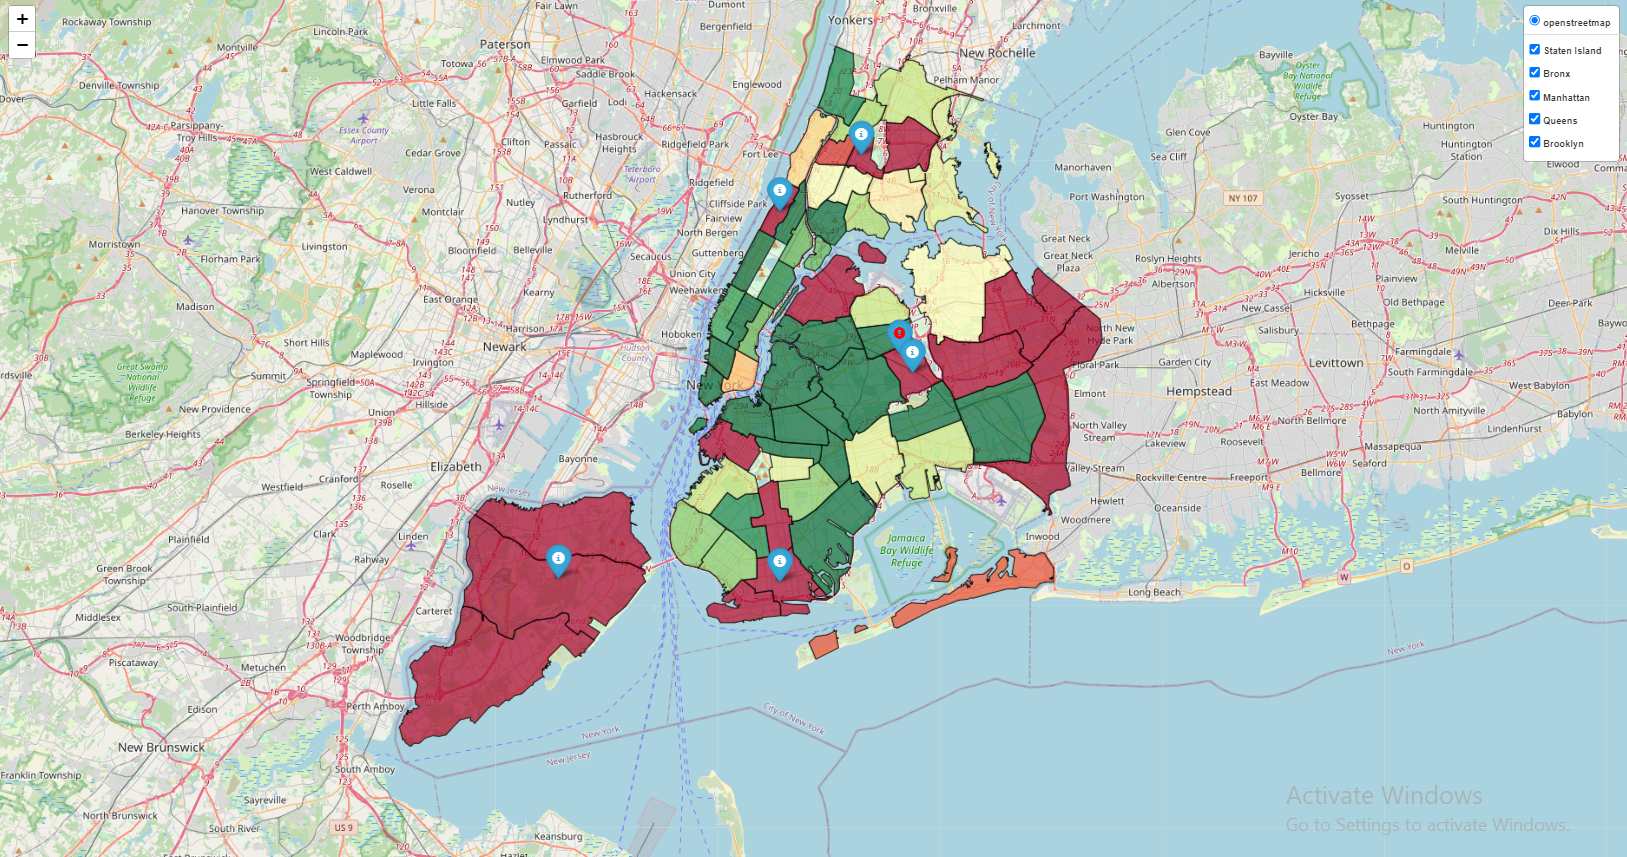


<div class="alert alert-block alert-success">
<b>For more comprehencive analysis of the NYC energy consumption the population dataset per subdistrict is added to the report</b> 


In [10]:
NYC_Population=pd.read_csv('New_York_City_Population_By_Community_Districts_20231228.csv')
NYC_df=gdf_transformed.merge(NYC_Population, how='left', left_on='DISTRICT', right_on='Borough_ID')

<div class="alert alert-block alert-info">
<b>Chart N2:</b> 
</div>
The interactive map presented below utilizes color shading to depict population density per subdistrict, with each point overlaid on the map representing the precise location of a building sourced from the original dataset. A notable revelation emerges as Queens - the most populated area in terms of residents, exhibits a lower concentration of buildings. Conversely, Manhattan appears to be densely populated with buildings, a phenomenon that is particularly intriguing when considering the energy use data from the aforementioned chart. Notably, Queens emerges as the least energy-efficient district, suggesting a residential focus where individuals consume more energy in their homes than in urban areas.
However, the are withe highest average Site EUI (kBtu/ft²) - Queens N13 is not populated in compared to rest of the district, hence some of the buildings might me indeed inneficient there.

Simultaneously, attention is drawn to Staten Island, which displays a significant energy consumption pattern despite being visibly less populated on the map in both terms of people and buildings. This observation prompts further investigation into the unique dynamics of energy consumption within Staten Island, possibly revealing distinctive factors influencing energy usage patterns in this less densely populated region of New York.

In [ ]:
NYC_df = NYC_df.sort_values(by='Population', ascending=False)
districts_map = folium.Map(location=[40.708800, -73.995140], zoom_start=11)
colormap = linear.RdYlGn_11.scale(min(NYC_df['Population']), max(NYC_df['Population']))
colormap.colors.reverse()
def color_function(x):
    if x['properties']['Population'] is None:
        return 'gray' 
    else:
        return colormap(x['properties']['Population'])
geojson_layer = folium.GeoJson(
    NYC_df,
    style_function=lambda x: {
        'fillColor': color_function(x),
        'color': 'black',
        'weight': 1,
        'fillOpacity': 0.7
    },
    highlight_function=lambda x: {
        'fillColor': 'yellow',
        'color': 'black',
        'weight': 2,
        'fillOpacity': 0.7
    },
    tooltip=folium.features.GeoJsonTooltip(
        fields=['District_Name','DISTRICT', 'Population'],
        aliases=['District_Name','District Name', 'Population'],
        style=("background-color: white; color: #333333; font-size: 12px; padding: 10px;")
    ),
    name='Population'
).add_to(districts_map)

\
scatter_layer = folium.FeatureGroup(name='Building Placement').add_to(districts_map)
for _, row in T2.iterrows():
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        radius=0.5,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=1e-7
    ).add_to(scatter_layer)

folium.LayerControl(collapsed=False).add_to(districts_map)
colormap.add_to(districts_map)

districts_map


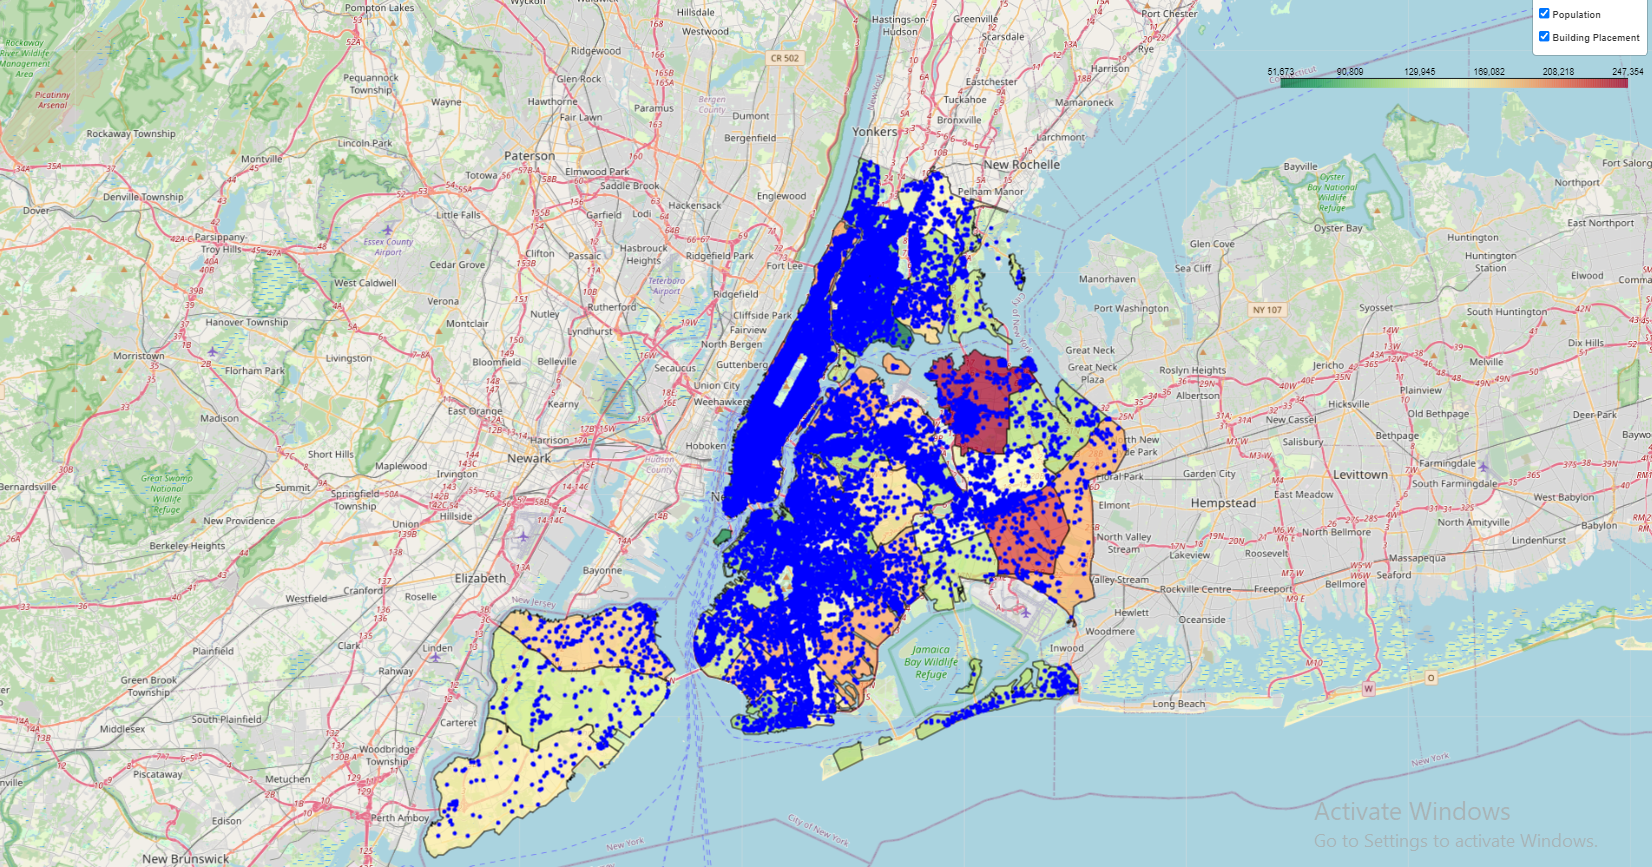

For the following analysis, the construction years of buildings have been rounded to facilitate a broader chronological perspective, with years such as 1933 being rounded to 1930. This approach ensures a comprehensive timeline spanning from 1800 to 2020. In conjunction with this temporal adjustment, the number of buildings constructed in each rounded year is computed, along with the corresponding average Site Energy Use Intensity (Site EUI) measured in kBtu/ft². This dual analysis provides insights into the distribution of building construction over time, coupled with an examination of the associated average Site EUI values, offering a nuanced understanding of the evolving energy efficiency trends in the dataset.

In [15]:
NYC_Final['Round_Year'] = (NYC_Final['Year Built'] / 100).round(1) * 100
T4 = NYC_Final[NYC_Final['Year Built'].between(1800, 2023)]
T5 = T4[['Site EUI (kBtu/ft²)', 'Round_Year', 'District_Name']]

result = T5.groupby(['Round_Year', 'District_Name']).agg({'Site EUI (kBtu/ft²)': 'mean', 'Round_Year': 'count'})
result = result.rename(columns={'Round_Year': 'Count_Year'}).reset_index()

result['Round_Year']=result['Round_Year'].astype(int)
result.sort_values(by='Count_Year', ascending=False).head()

Round_Year District_Name  Site EUI (kBtu/ft²)  Count_Year
45        1920     Manhattan            80.563451        2097
49        1930      Brooklyn            85.921908        1723
48        1930         Bronx            85.946016        1538
50        1930     Manhattan            78.101702        1493
40        1910     Manhattan            81.905087        1355

<div class="alert alert-block alert-info">
<b>Chart N3:</b> 
</div>

In the interactive charts below, the X-axis is dedicated to the display of rounded years, spanning from 1800 to 2020. A noteworthy observation arises, indicating that around the year 1870, Staten Island boasts approximately 11 buildings that exhibit the highest energy consumption within this dataset.

Further analysis reveals an interesting trend in Manhattan and Brooklyn, where a significant portion of buildings dates back to earlier years. Given that Manhattan and Brooklyn are among the oldest districts in the city, this distribution aligns with historical development patterns. Surprisingly, despite the age of these structures, the energy consumption remains relatively balanced. This observation prompts an inference that older buildings may, in fact, demonstrate a degree of energy efficiency, challenging conventional assumptions about the correlation between building age and energy consumption.

In [ ]:

result = result.rename(columns={'Count_Year': 'Count'})
selection = alt.selection_multi(fields=['District_Name'], bind='legend')
circle_size = 150
chart_mean_eui = alt.Chart(result).mark_circle(tooltip=True, size=circle_size).encode(
    x=alt.X('Round_Year:O', title='Round Year'),
    y=alt.Y('mean(Site EUI (kBtu/ft²)):Q', title='Mean Site EUI (kBtu/ft²)'),
    color=alt.condition(selection, 'District_Name:N', alt.value('lightgrey')),
    tooltip=[alt.Tooltip('mean(Site EUI (kBtu/ft²)):Q', title='Mean Site EUI (kBtu/ft²)')]
).add_selection(selection).properties(width=500)

chart_count_buildings = alt.Chart(result).mark_circle(tooltip=True, size=circle_size).encode(
    x=alt.X('Round_Year:O', title='Round Year'),
    y=alt.Y('Count:Q', title='Count of Buildings'),
    color=alt.condition(selection, 'District_Name:N', alt.value('lightgrey')),
    tooltip=[alt.Tooltip('Round_Year:N', title='Year built'),
             alt.Tooltip('Count:Q', title='Count of Buildings')]
).add_selection(selection).properties(width=500)
combined_chart = alt.hconcat(chart_mean_eui, chart_count_buildings)
combined_chart


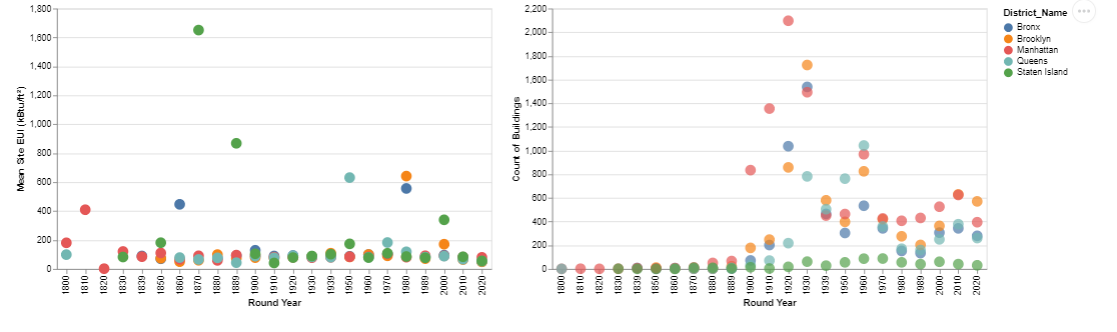

<div class="alert alert-block alert-info">
<b>Chart N4:</b> 
</div>

The heatmaps displayed below provide a visual representation of utility consumption across four distinct categories by the year of building construction. Notably, in Manhattan, electricity consumption peaks among buildings constructed in 1870. Conversely, Staten Island exhibits the highest rates of both electricity and natural gas consumption for buildings erected in 2000. This suggests that on Staten Island, energy inefficiency may not solely stem from elevated consumption rates but could also be influenced by the ratio of energy use per floor area. Therefore, despite newer buildings demonstrating higher energy usage, their relatively larger size may contribute to a more nuanced understanding of energy efficiency trends.

In [ ]:
def create_chart(data, x_field, y_field, color_field, title, width=400, height=400):
    chart = alt.Chart(data).mark_rect().encode(
        y=alt.Y(f'{y_field}:O', title='District Name'),
        x=alt.X(f'{x_field}:O', title='Round Year'),
        color=alt.Color(f'{color_field}:Q', title='Value'),
        
    tooltip=['Round_Year', 'District_Name']
    ).properties(
        title=title,
        width=width,
        height=height
    )
    return chart

nyc_final = NYC_Final[NYC_Final['Year Built'].between(1899, 2023)]

columns = [
    ('Electricity - Weather Normalized Site Electricity Use (Grid and Onsite Renewables) (kWh)', 'Electricity'),
    ('Natural Gas - Weather Normalized Site Natural Gas Use (therms)', 'Natural Gas'),
    ('Fuel Oil #2 Use (kBtu)', 'Fuel Oil #2'),
    ('Water Use (All Water Sources) (kgal)', 'Water')
]
for column, field in columns:
    # Group by and aggregate data
    grouped_data = nyc_final.groupby(['District_Name', 'Round_Year'])[column].mean().reset_index()
    grouped_data['Round_Year'] = grouped_data['Round_Year'].astype(int)

    chart = create_chart(grouped_data, 'Round_Year', 'District_Name', column, f'{field} by District and Round Year', width=600, height=300)
    chart.display()


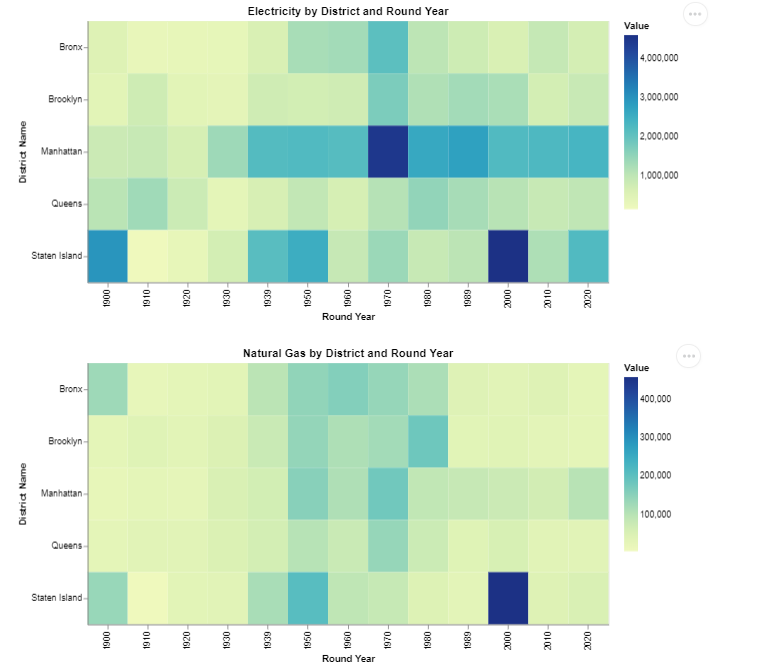
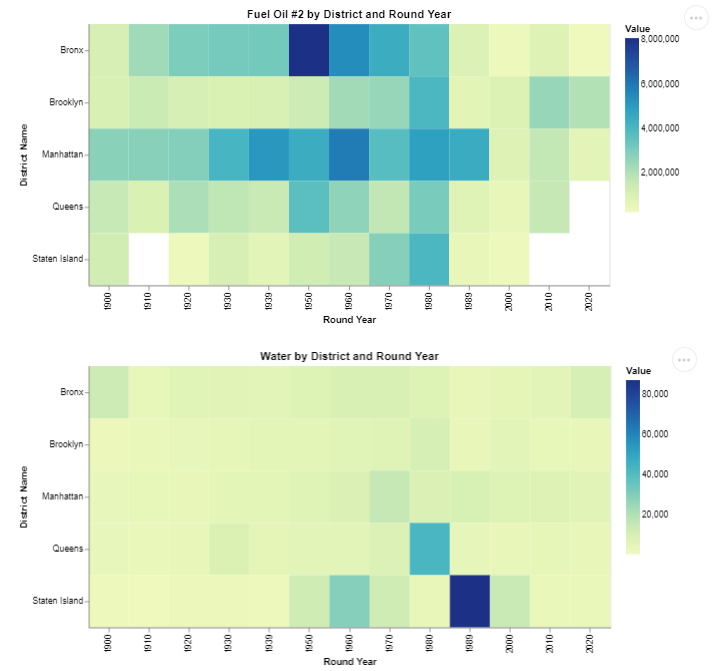

<div class="alert alert-block alert-success">
<b>Conclusion: </b>  The report clearly points out that Queens needs closer attention regarding its energy use. Despite being less crowded than Manhattan, it performs poorly and emits a significant amount of CO2. While Brooklyn, Bronx, and Manhattan are generally more efficient, there are some areas within them that might need extra focus.

Moreover, Staten Island is also not very energy-efficient. Newer buildings there use a lot of utilities, and smaller buildings, although using a good amount of energy, have a lower energy efficiency score due to their smaller size. This analysis gives us a better understanding of where improvements can be made in each district.